In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader
from torchvision.datasets import EuroSAT
from src.EuroSat_dataloaders import transformation_eurosat
import torch
import torchvision
from torch.utils.data import Dataset,DataLoader
from tqdm import tqdm
import torchmetrics.classification

from src.EuroSat_dataloaders import transformation_eurosat
from torchvision.datasets import EuroSAT
from torchvision.transforms import v2
from torch.utils.data import Dataset,DataLoader

from src.EuroSat_dataloaders import Train_Dataset_EuroSat,Test_Dataset_EuroSat
# statistics of dataset
transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


In [55]:
transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

In [56]:
resnet50 = torch.load("finished\\ResNet50\\resnet50_model.pth")
resnet50.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\transforms\v2\_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `transforms.Compose([transforms.ToImageTensor(), transforms.ConvertImageDtype()])`.
  warnings.warn(


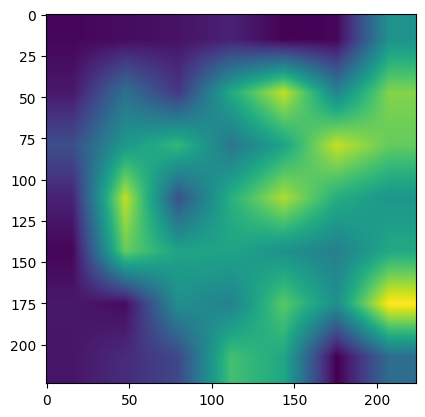

(224, 224)


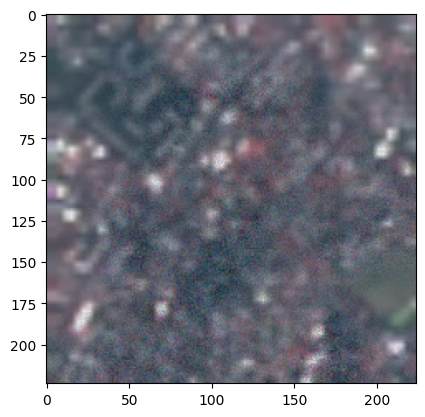

torch.Size([1, 3, 224, 224])


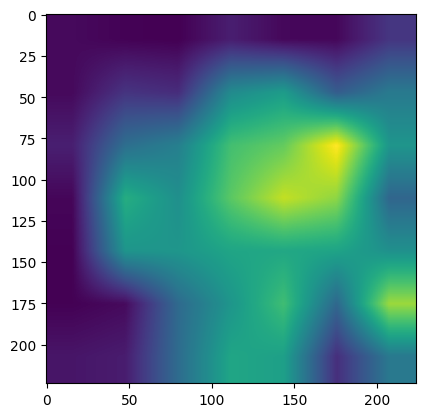

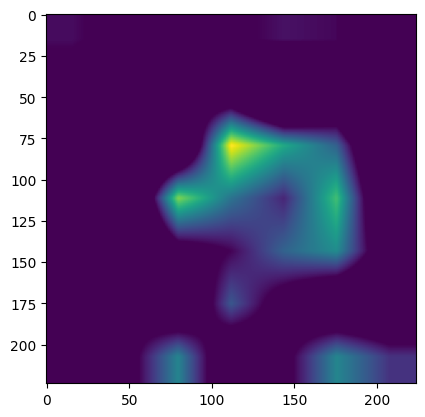

In [57]:
from pytorch_grad_cam import GradCAM, GradCAMPlusPlus
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
import matplotlib.pyplot as plt
import numpy as np
from src.faithfulness.perturbation import eurosat_perturbation, thr_fc, thr_fc_bin
from src.faithfulness.silency_map import Silency_map_gen
# model

resnet50 = torch.load("finished\\ResNet50\\resnet50_model.pth")
resnet50.cuda()

# dataset:

transforms = v2.Compose([
    v2.ToTensor(),
    v2.ToDtype(torch.float32),
    v2.Resize(224,antialias=None),
])
ds = EuroSAT("../EuroSat",transform=transforms,target_transform=transformation_eurosat,download=False)
ds_test = Test_Dataset_EuroSat(ds)

# target layer:
nr = 25
cam_type = "grad_cam_plus_plus"



resnet50_no_softmax = torch.load("finished\\ResNet50\\resnet50_model.pth")
resnet50_no_softmax.cuda()
fc_ = list(resnet50_no_softmax.fc)[:-1]
resnet50_no_softmax.fc = torch.nn.Sequential(*fc_)

target_layers = [resnet50_no_softmax.layer4[-1]]
targets = None

sil_gen = Silency_map_gen(resnet50_no_softmax, ds_test, target_layers)

mask = sil_gen.get_silency_map(nr,targets, cam_type)
plt.imshow(mask)
plt.show()
print(mask.shape)
#mask = thr_fc(mask)

input_tensor = eurosat_perturbation(sil_gen.ds[nr][0],mask).unsqueeze(0).cuda()
minimum = torch.min(input_tensor)
maximum = torch.max(input_tensor)
plt.imshow((input_tensor[0].T.cpu()-minimum.cpu())/(maximum.cpu() - minimum.cpu()))
plt.show()
print(input_tensor.shape)
pert_im = sil_gen.get_silency_map_(input_tensor,targets, cam_type)
plt.imshow(pert_im)
plt.show()
plt.imshow((pert_im-mask)*(pert_im-mask > 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


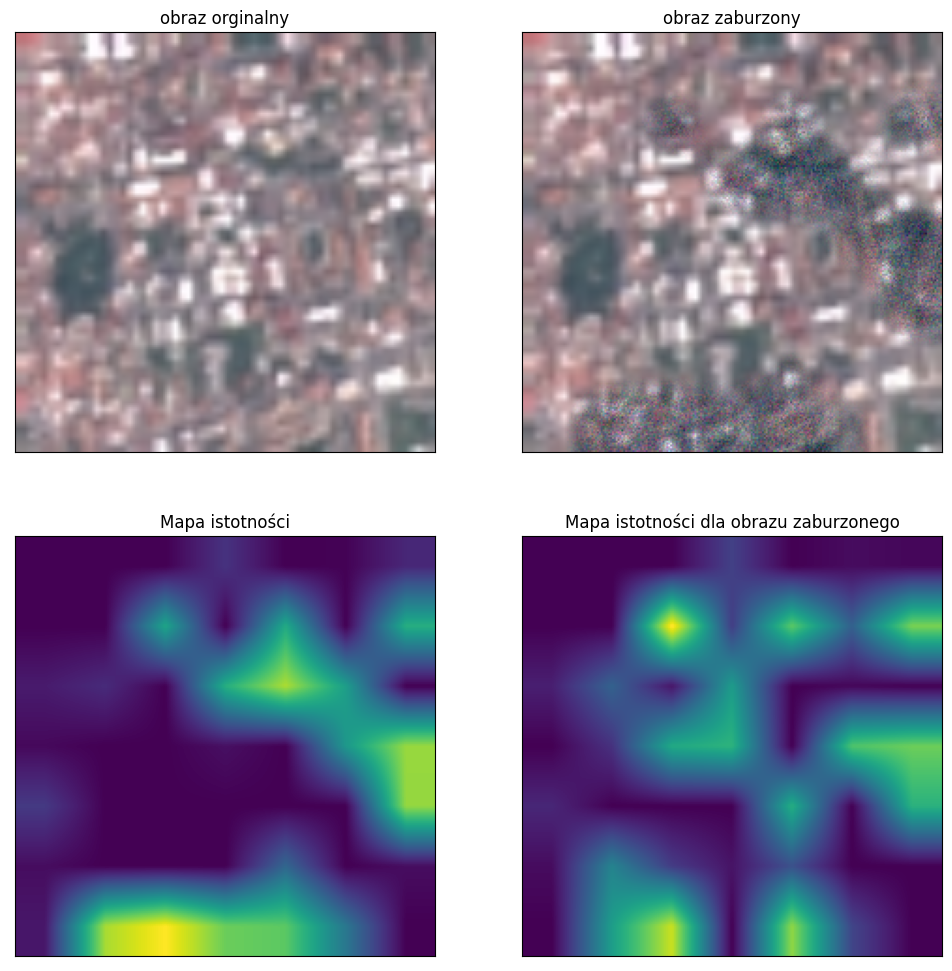

0.15043771
(224, 224, 3)


In [41]:
nr = 9
sl , pert_sl = sil_gen.get_pair_sailency(nr)
mask = thr_fc(sl)
input_tensor = eurosat_perturbation(sil_gen.ds[nr][0],mask).unsqueeze(0).cuda()
minimum = torch.min(input_tensor)
maximum = torch.max(input_tensor)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
ax[1,0].imshow(sl)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title(f"Mapa istotności")
ax[1,1].imshow(pert_sl)
ax[1,1].set_title(f"Mapa istotności dla obrazu zaburzonego")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[0,0].imshow(torch.transpose((sil_gen.ds[nr][0].T+1)/2,1,0).numpy())
ax[0,0].set_title(f"obraz orginalny")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].imshow(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy())
ax[0,1].set_title(f"obraz zaburzony")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
plt.show()
print(np.max(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy()-torch.transpose((sil_gen.ds[nr][0].T+1)/2,1,0).numpy()))
print(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy().shape)

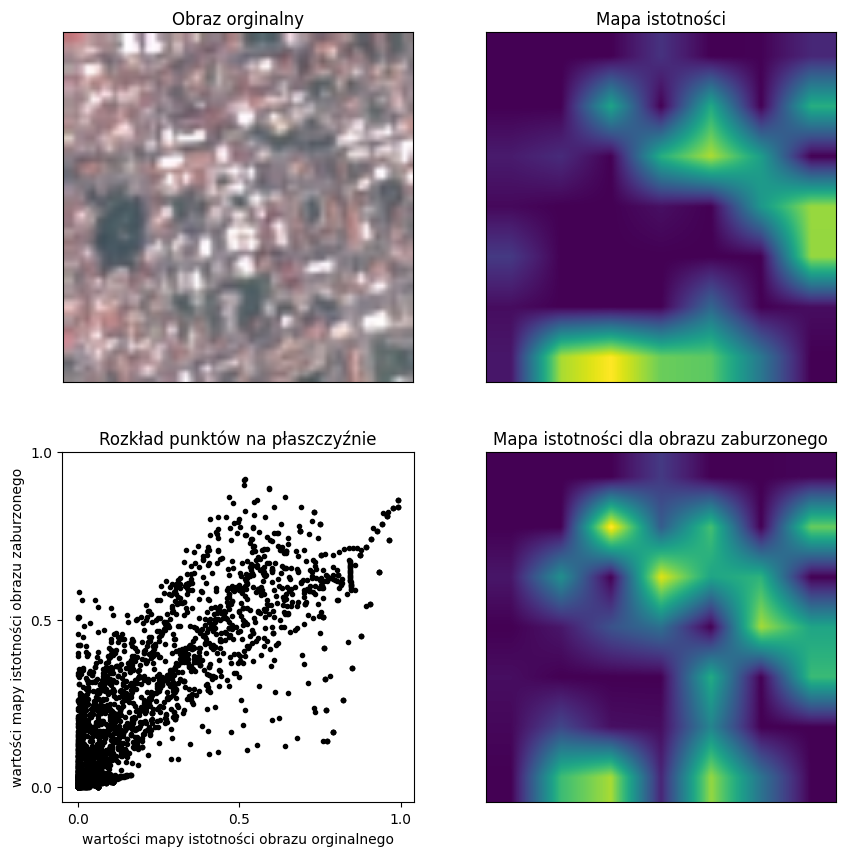

0.9999999


In [53]:
nr = 9
sl , pert_sl = sil_gen.get_pair_sailency(nr)
mask = thr_fc(sl)
input_tensor = eurosat_perturbation(sil_gen.ds[nr][0],mask).unsqueeze(0).cuda()
minimum = torch.min(input_tensor)
maximum = torch.max(input_tensor)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(10,10)
ax[0,1].imshow(sl)
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[0,1].set_title(f"Mapa istotności")
ax[1,1].imshow(pert_sl)
ax[1,1].set_title(f"Mapa istotności dla obrazu zaburzonego")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[0,0].imshow(torch.transpose((sil_gen.ds[nr][0].T+1)/2,1,0).numpy())
ax[0,0].set_title(f"Obraz orginalny")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])

sl = sl.flatten()
pert_sl = pert_sl.flatten()

ax[1,0].plot(sl[1::20],pert_sl[1::20],'.k')
ax[1,0].set_title(f"Rozkład punktów na płaszczyźnie")
ax[1,0].set_xticks([0,0.5,1])
ax[1,0].set_yticks([0,0.5,1])
ax[1,0].set_xlabel("wartości mapy istotności obrazu orginalnego")
ax[1,0].set_ylabel("wartości mapy istotności obrazu zaburzonego")
plt.show()
print(sl.max())

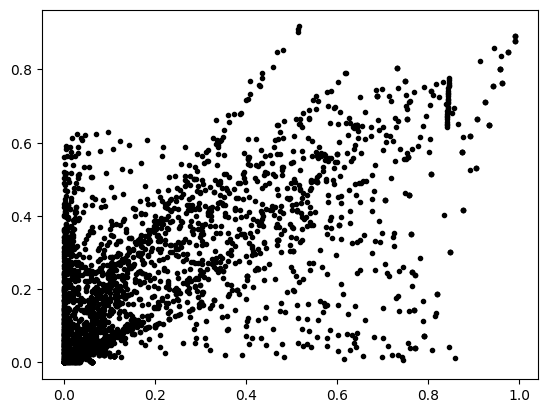

In [42]:
sl = sl.flatten()
pert_sl = pert_sl.flatten()
plt.plot(sl[1::20],pert_sl[1::20],'.k')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


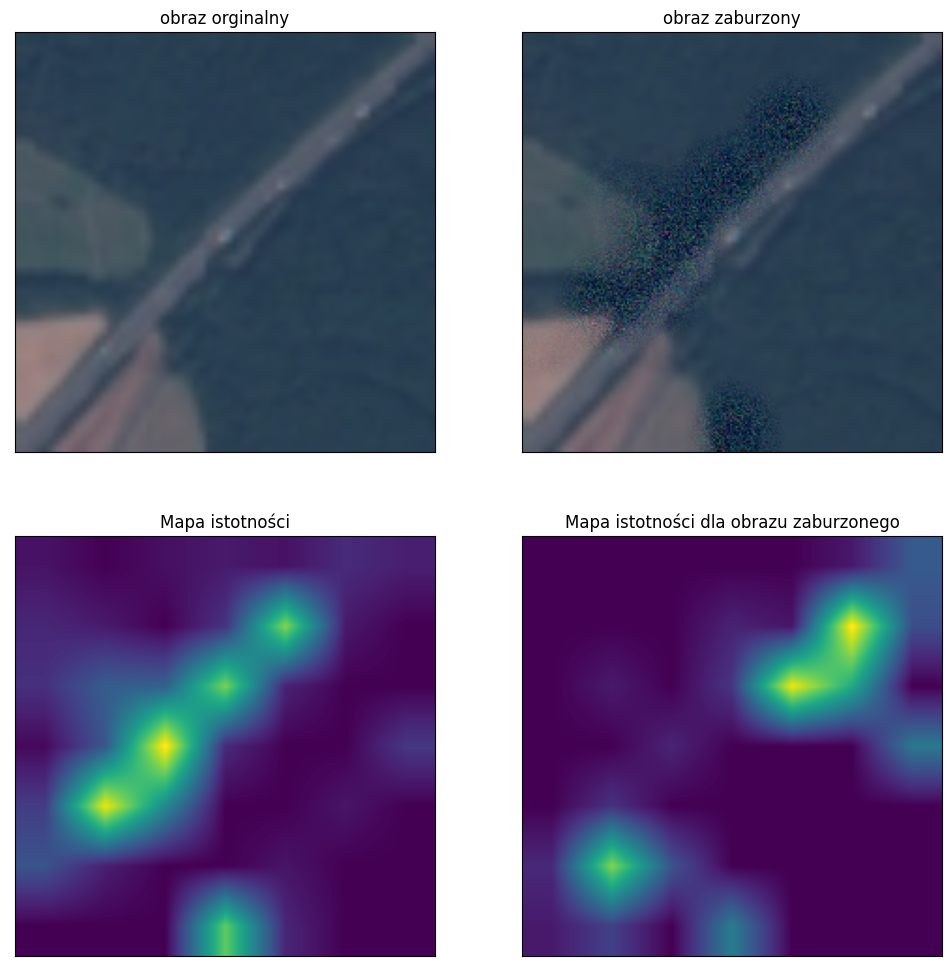

0.335421
(224, 224, 3)


In [21]:
nr = 2
sl , pert_sl = sil_gen.get_pair_sailency(nr)
mask = thr_fc(sl)
input_tensor = eurosat_perturbation(sil_gen.ds[nr][0],mask).unsqueeze(0).cuda()
minimum = torch.min(input_tensor)
maximum = torch.max(input_tensor)

fig,ax = plt.subplots(2,2)
fig.set_size_inches(12,12)
ax[1,0].imshow(sl)
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])
ax[1,0].set_title(f"Mapa istotności")
ax[1,1].imshow(pert_sl)
ax[1,1].set_title(f"Mapa istotności dla obrazu zaburzonego")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])
ax[0,0].imshow(torch.transpose((sil_gen.ds[nr][0].T+1)/2,1,0).numpy())
ax[0,0].set_title(f"obraz orginalny")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[0,1].imshow(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy())
ax[0,1].set_title(f"obraz zaburzony")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
plt.show()
print(np.max(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy()-torch.transpose((sil_gen.ds[nr][0].T+1)/2,1,0).numpy()))
print(torch.transpose((input_tensor[0].T.cpu()+1)/2,1,0).numpy().shape)

3


[]

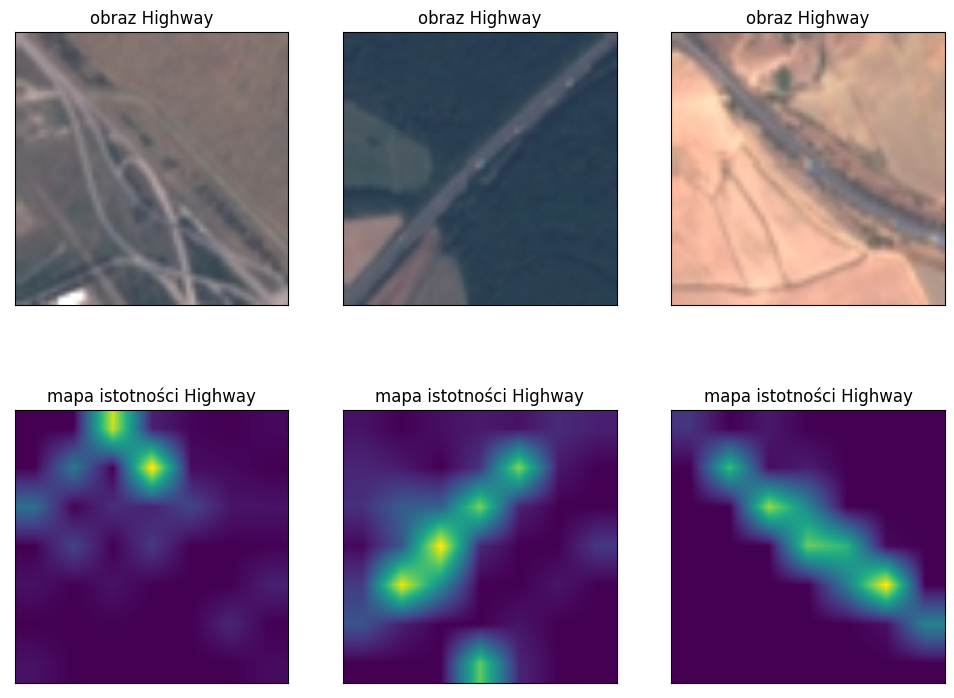

In [7]:
nr = 2
sl , pert_sl, pred = sil_gen.get_pair_sailency(nr,return_pred = True)
im = torch.transpose((sil_gen.ds[nr][0].T.cpu()+1)/2,1,0).numpy()
p = int(torch.argmax(sil_gen.ds[nr][1].cpu()))
print(pred)
DS_LABELS = ["AnnualCrop", "Forest", "HerbaceousVegetation", "Highway","Industrial","Pasture","PermanentCrop",
             "Residential", "River", "SeaLake"]
fig,ax = plt.subplots(2,3)
fig.set_size_inches(12,9)
ax[0,1].imshow(im)
ax[0,1].set_title(f"obraz {DS_LABELS[p]}")
ax[0,1].set_xticks([])
ax[0,1].set_yticks([])
ax[1,1].imshow(sl)
ax[1,1].set_title(f"mapa istotności {DS_LABELS[pred]}")
ax[1,1].set_xticks([])
ax[1,1].set_yticks([])

nr = 97
sl , pert_sl, pred = sil_gen.get_pair_sailency(nr,return_pred = True)
im = torch.transpose((sil_gen.ds[nr][0].T.cpu()+1)/2,1,0).numpy()
p = int(torch.argmax(sil_gen.ds[nr][1].cpu()))

ax[0,0].imshow(im)
ax[0,0].set_title(f"obraz {DS_LABELS[p]}")
ax[0,0].set_xticks([])
ax[0,0].set_yticks([])
ax[1,0].imshow(sl)
ax[1,0].set_title(f"mapa istotności {DS_LABELS[pred]}")
ax[1,0].set_xticks([])
ax[1,0].set_yticks([])

nr = 107
sl , pert_sl, pred = sil_gen.get_pair_sailency(nr,return_pred = True)
im = torch.transpose((sil_gen.ds[nr][0].T.cpu()+1)/2,1,0).numpy()
p = int(torch.argmax(sil_gen.ds[nr][1].cpu()))

ax[0,2].imshow(im)
ax[0,2].set_title(f"obraz {DS_LABELS[p]}")
ax[0,2].set_xticks([])
ax[0,2].set_yticks([])
ax[1,2].imshow(sl)
ax[1,2].set_title(f"mapa istotności {DS_LABELS[pred]}")
ax[1,2].set_xticks([])
ax[1,2].set_yticks([])

In [8]:
def NSS_func(sl_map, pert_sl_map, tr_fc = thr_fc_bin):
    sl_map_bin = tr_fc(sl_map)
    if(np.std(pert_sl_map) != 0):
        sl_map_norm = (sl_map-np.mean(pert_sl_map))/(2*np.std(pert_sl_map))
    else:
        sl_map_norm = (sl_map-np.mean(pert_sl_map))
    sum_of_pixel_path = 0.0
    count = 0
    for i in range(len(sl_map)):
        for j in range(len(sl_map)):
            if(sl_map_bin[i][j] == 1):
                sum_of_pixel_path += sl_map_norm[i][j]
                count += 1
    if(count == 0):
        return 0
    return sum_of_pixel_path/float(count)


In [9]:
nr = 14
sl , pert_sl = sil_gen.get_pair_sailency(nr)
print(NSS_func(sl , pert_sl))

0.6637787264737015


In [10]:
def IG_func(sl_map, pert_sl_map, baseline_sl_map, e=1, tr_fc = thr_fc_bin):
    sl_map_bin = tr_fc(sl_map)
    count = 0
    sum_of_pixel = 0.0
    for i in range(len(sl_map)):
        for j in range(len(sl_map)):
            if(sl_map_bin[i][j] == 1):
                sum_of_pixel += np.log2(pert_sl_map[i][j] + e) - np.log2(baseline_sl_map[i][j] + e)
                count += 1
    return sum_of_pixel/float(count)

In [11]:
# Baseline image count:
baseline_im = torch.zeros(sil_gen.ds[0][0].shape)
baseline_sl = sil_gen.get_silency_map_input(baseline_im)
print(IG_func(sl , pert_sl, baseline_sl))

0.09721811448502546


In [12]:
def MSE_func(sil_gen, nr, model, perturbation_fc = eurosat_perturbation):
    mask = sil_gen.get_silency_map(nr)
    input_tensor_pert = perturbation_fc(sil_gen.ds[nr][0],mask).unsqueeze(0).cuda()
    input_tensor = sil_gen.ds[nr][0].unsqueeze(0).cuda()
    y = model(input_tensor)
    y_pert = model(input_tensor_pert)
    return float(torch.sum(((y-y_pert))**2).cpu())

nr = 5
print(MSE_func(sil_gen, nr, resnet50))

1.4541855920350118e-29


c:\Users\nikos\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\container.py:217: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [13]:
def SIM_func(sl_map, pert_sl_map, no_bins = 20, show = False):
    upper = np.max([np.max(sl_map),np.max(pert_sl_map)])
    hist_sl = torch.histogram(torch.from_numpy(sl_map),no_bins,range=(0.0,upper),density = True)
    hist_pert_sl = torch.histogram(torch.from_numpy(pert_sl_map),no_bins,range=(0.0,upper),density = True)
    if show:
        plt.plot(hist_sl.bin_edges.numpy()[1:],hist_sl.hist.numpy())
        plt.show()
        plt.plot(hist_pert_sl.bin_edges.numpy()[1:],hist_pert_sl.hist.numpy())
        plt.show()
    return np.sum(np.minimum(hist_sl.hist.numpy(),hist_pert_sl.hist.numpy()))

In [14]:
nr = 100
sl , pert_sl = sil_gen.get_pair_sailency(nr)
SIM_func(sl , pert_sl)

17.08586

In [15]:
def CC_func(sl_map, pert_sl_map, no_bins = 20, show = False):
    upper = np.max([np.max(sl_map),np.max(pert_sl_map)])
    if upper == 0:
        return 0
    hist_sl = torch.histogram(torch.from_numpy(sl_map),no_bins,range=(0.0,upper),density = True)
    hist_pert_sl = torch.histogram(torch.from_numpy(pert_sl_map),no_bins,range=(0.0,upper),density = True)
    if show:
        plt.plot(hist_sl.bin_edges.numpy()[1:],hist_sl.hist.numpy())
        plt.show()
        plt.plot(hist_pert_sl.bin_edges.numpy()[1:],hist_pert_sl.hist.numpy())
        plt.show()
    temp = np.std(hist_sl.hist.numpy())*np.std(hist_pert_sl.hist.numpy())
    if temp == 0:
        return 0
    cc = np.mean((hist_sl.hist.numpy()-np.mean(hist_sl.hist.numpy()))*(hist_pert_sl.hist.numpy()-np.mean(hist_pert_sl.hist.numpy())))/(temp)
    if np.isnan(cc):
        return 0
    return np.mean((hist_sl.hist.numpy()-np.mean(hist_sl.hist.numpy()))*(hist_pert_sl.hist.numpy()-np.mean(hist_pert_sl.hist.numpy())))/(temp)

In [16]:
nr = 1
sl , pert_sl = sil_gen.get_pair_sailency(nr)
CC_func(sl , pert_sl)

0.9162388

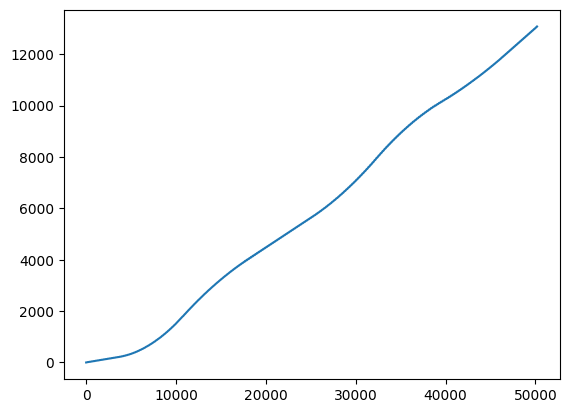

In [17]:
hist_sl = sl.cumsum()
plt.plot(hist_sl)
plt.hlines(np.mean(sl),0,18)

In [18]:
sum_CC = 0.0
# for i,tq in zip(range(len(ds_test)),tqdm.tqdm(range(len(ds_test)))):
#     sl , pert_sl = sil_gen.get_pair_sailency(i)
#     sum_CC += CC_func(sl , pert_sl)
print(f"średni współczynnik korelacji: {sum_CC/len(ds_test)}")

średni współczynnik korelacji: 0.0
